# 02 — Plot Soundings Envelope (Base vs Range)
Plots the **base sounding** as a thick line and the **range (min–max)** of a collection as a fill.
Use either a folder of `input_sounding_*` files or generate analytic soundings on the fly.

In [1]:
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.insert(0, str(SRC))
from envgen_analytic import generate_sounding


In [2]:
# --- CONFIG ---
MODE = 'folder'   # 'folder' or 'analytic'
SOUNDINGS_DIR = str(REPO_ROOT / 'outputs' / 'soundings')
BASE_PATH = str(REPO_ROOT / 'wrf_case' / 'input_sounding')  # optional base
N_ANALYTIC = 256   # when MODE='analytic'


In [3]:
def read_input_sounding(path):
    arr = np.loadtxt(path, comments='#', skiprows=1)
    p, T, qv, u, v, z = arr.T
    return dict(p=p, t=T, qv=qv, u=u, v=v, height=z)

def dewpoint_from_qv(p_hpa, qv_gkg):
    epsilon = 0.622
    r = qv_gkg / 1000.0
    p_pa = p_hpa * 100.0
    e_pa = (r / (epsilon + r)) * p_pa
    e_hpa = e_pa / 100.0
    ln_ratio = np.log(np.maximum(e_hpa, 1e-6) / 6.112)
    Td_C = (243.5 * ln_ratio) / (17.67 - ln_ratio)
    return Td_C + 273.15

def interp_to(z_src, x_src, z_tgt):
    return np.interp(z_tgt, z_src.astype(float), x_src.astype(float))


In [4]:
# Load base sounding (or fallback to first in folder; or analytic median case)
base = None
if os.path.exists(BASE_PATH):
    base = read_input_sounding(BASE_PATH)
else:
    files = sorted(glob.glob(os.path.join(SOUNDINGS_DIR, 'input_sounding_*')))
    if files:
        base = read_input_sounding(files[0])
if base is None and MODE=='analytic':
    base = generate_sounding([0.5]*10)
assert base is not None, 'No base sounding available'
zb = base['height']; Tb = base['t']; qvb = base['qv']; pb = base['p']; ub = base['u']; vb = base['v']
Tdb = dewpoint_from_qv(pb, qvb)


In [5]:
# Build collection
coll = []
if MODE=='folder':
    files = sorted(glob.glob(os.path.join(SOUNDINGS_DIR, 'input_sounding_*')))
    if not files:
        raise SystemExit('No input_sounding_* files in SOUNDINGS_DIR')
    for fp in files:
        s = read_input_sounding(fp); coll.append(s)
elif MODE=='analytic':
    rng = np.random.default_rng(123)
    U = rng.random((N_ANALYTIC, 10))
    for u in U:
        coll.append(generate_sounding(u.tolist()))
else:
    raise ValueError('Unknown MODE')
len(coll)

6144

In [6]:
# Interpolate to base grid and compute envelopes
T_list, Td_list, qv_list, wspd_list = [], [], [], []
for s in coll:
    z = s['height']; T = s['t']; qv = s['qv']; p = s['p']; u = s['u']; v = s['v']
    Td = dewpoint_from_qv(p, qv)
    wspd = np.sqrt(u**2 + v**2)
    T_list.append(interp_to(z, T, zb))
    Td_list.append(interp_to(z, Td, zb))
    qv_list.append(interp_to(z, qv, zb))
    wspd_list.append(interp_to(z, wspd, zb))

T_arr    = np.vstack(T_list)
Td_arr   = np.vstack(Td_list)
qv_arr   = np.vstack(qv_list)
wspd_arr = np.vstack(wspd_list)

T_min, T_max       = T_arr.min(axis=0), T_arr.max(axis=0)
Td_min, Td_max     = Td_arr.min(axis=0), Td_arr.max(axis=0)
qv_min, qv_max     = qv_arr.min(axis=0), qv_arr.max(axis=0)
wspd_min, wspd_max = wspd_arr.min(axis=0), wspd_arr.max(axis=0)


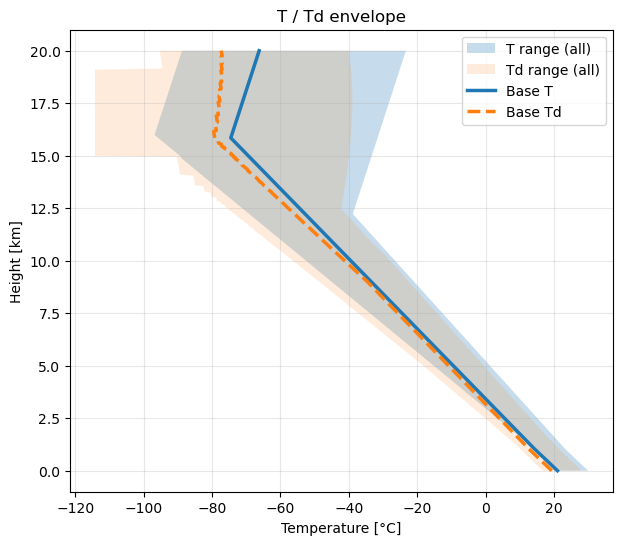

In [7]:
# 1) T/Td vs height
z_km = zb/1000.0
plt.figure(figsize=(7,6))
plt.fill_betweenx(z_km, T_min-273.15, T_max-273.15, alpha=0.25, label='T range (all)')
plt.fill_betweenx(z_km, Td_min-273.15, Td_max-273.15, alpha=0.15, label='Td range (all)')
plt.plot(Tb-273.15, z_km, lw=2.5, label='Base T')
plt.plot(Tdb-273.15, z_km, lw=2.5, ls='--', label='Base Td')
plt.xlabel('Temperature [°C]'); plt.ylabel('Height [km]'); plt.title('T / Td envelope')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


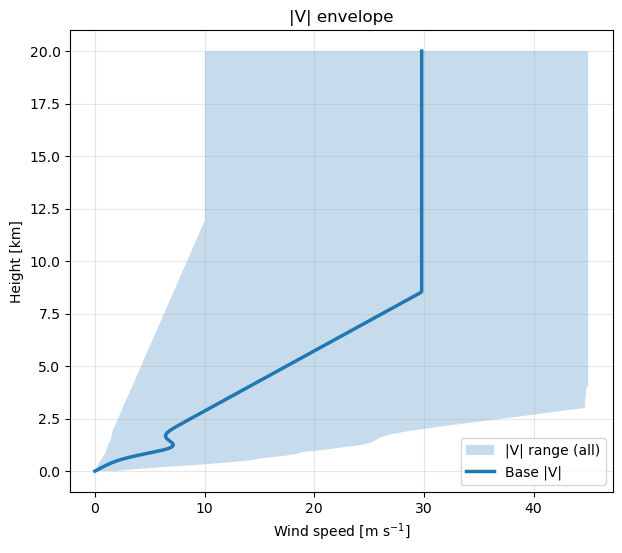

In [8]:
# 2) Wind speed vs height
wspd_b = np.sqrt(ub**2 + vb**2)
plt.figure(figsize=(7,6))
plt.fill_betweenx(z_km, wspd_min, wspd_max, alpha=0.25, label='|V| range (all)')
plt.plot(wspd_b, z_km, lw=2.5, label='Base |V|')
plt.xlabel('Wind speed [m s$^{-1}$]'); plt.ylabel('Height [km]'); plt.title('|V| envelope')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


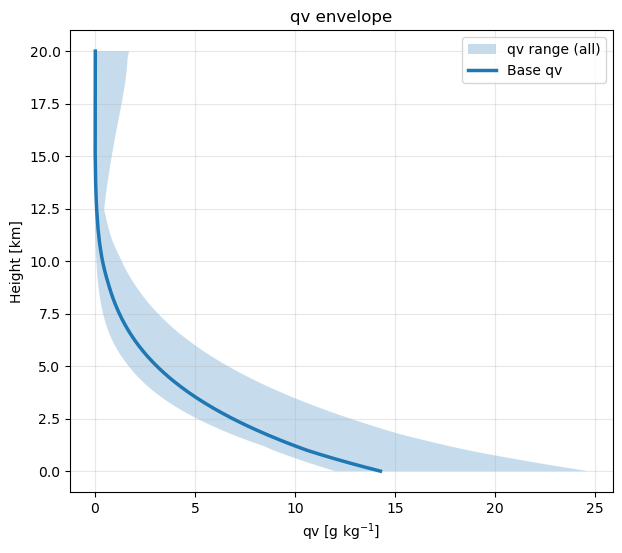

In [9]:
# 3) qv vs height
plt.figure(figsize=(7,6))
plt.fill_betweenx(z_km, qv_min, qv_max, alpha=0.25, label='qv range (all)')
plt.plot(qvb, z_km, lw=2.5, label='Base qv')
plt.xlabel('qv [g kg$^{-1}$]'); plt.ylabel('Height [km]'); plt.title('qv envelope')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


In [ ]:
import matplotlib.pyplot as plt
from metpy.plots import SkewT, Hodograph
import metpy.calc as mpcalc
from metpy.units import units

# Variables globales para guardar referencias a objetos gráficos
lines_skew = []
barbs = None
cape_shade = None
cin_shade = None
lines_hodo = []
colorbar_hodo = None
scatter_hodo = None

def prepare_skewt_hodograph():
    #SKEWT
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(12, 8))

    # Grid for plots
    skew = SkewT(fig, rotation=45, rect=(0.05,0.05,0.50,0.90))

    #add labels
    skew.ax.set_xlabel('Temperature (°C)',weight='bold')
    skew.ax.set_ylabel('Pressure (hPa)',weight='bold')

    # Set the limits of the plot
    skew.ax.set_xlim(-20, 40)
    skew.ax.set_ylim(1050, 100)

    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidths=0.8)
    skew.plot_moist_adiabats(linewidths=0.8)
    skew.plot_mixing_lines(linewidths=0.8)
    
    #HODOGRAPH
    ax_h = fig.add_axes([0.54,0.67,0.28,0.28])
    h = Hodograph(ax_h, component_range=15)
    h.add_grid(increment = 5)

    ticks = np.arange(-15,20,5)
    h.ax.set_yticklabels([str(t) for t in ticks])
    h.ax.set_xticklabels([str(t) for t in ticks])
    h.ax.set_xticks(ticks)
    h.ax.set_yticks(ticks)
    h.ax.set_xlabel('U (m/s)',weight='bold')
    h.ax.set_ylabel('V (m/s)',weight='bold')
    h.ax.set_box_aspect(1)

    for i in range(10, 120, 10):
       h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                     clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    for i in range(10, 120, 10):
       h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                     clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

    #TEXT BOX
    ax_indices = fig.add_axes([0.345, 0.11, 0.5, 0.5])
    ax_indices.axis('off')  #no axis

    return fig, skew, h, ax_indices

def plot_sounding(fig, skew, h, ax_indices, my_data , alpha=1,show=False, return_artists = False )  :
    global barbs, cape_shade, cin_shade

    p=my_data['p'] * units.hPa
    t=my_data['t'] * units.kelvin
    t = t.to('degC')
    z=my_data['height'] * units.meter
    u=my_data['u'] * units.meter / units.second
    v=my_data['v'] * units.meter / units.second
    qv = my_data['qv'] / 1000 * units('kg/kg')
    td = mpcalc.dewpoint_from_specific_humidity(p,qv)
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot

    lt = skew.plot(p , t , 'r',alpha=alpha) [0]
    ltd = skew.plot(p , td , 'g',alpha=alpha) [0]
    
    # Barbas (guardar referencia para borrar luego)
    mask = p >= 100 * units.hPa
    if barbs is not None:
        try:
            barbs.remove()
        except:
            pass
    barbs = skew.plot_barbs(p[mask][::5],u[mask][::5],v[mask][::5],alpha=alpha)

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0] , t[0] , td[0]  )
    lcl_dot = skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black',alpha=alpha) [0]

    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p , t[0] , td[0] ).to('degC')
    prof_line = skew.plot(p, prof, 'k', linewidth=2,alpha=alpha) [0]

    lines_skew.extend([lt,ltd, prof_line, lcl_dot])

    # Shade areas of CAPE and CIN
    #cape_shade = skew.shade_cin(p,t,prof,alpha=0.3)
    #cin_shade = skew.shade_cape(p,t,prof,alpha=0.3)

    # Create a hodograph
    z_km = z.to('km')
    idx = np.argmin(np.abs(z_km.m - 10)) #index for 10km

    #Scatterplot by color
    points = h.ax.scatter(u[0:idx+1].m, v[0:idx+1].m, c=z_km[0:idx+1].m, cmap='gist_ncar', s=15)

    #Calculate indices
    # most unstable parcel properties!
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, t, td, depth=50 * units.hPa)

    # Compute Surface-based CAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, t, td)

    #Calculo LFC
    lfc = mpcalc.lfc(p, t, td)   #[0] es el nivel de presión y [1] es la temperatura

    # Copmute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)


    ax_indices.text(0.48, 0.95,f"   MUCAPE: {mucape.to('J/kg').m:.0f} J/kg        \n\n\n\n\n\n\n\n\n\n" , color = 'crimson',weight='bold',verticalalignment='top', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='palegoldenrod', edgecolor='white', alpha=1))
    ax_indices.text(0.48, 0.895,f"   SBCAPE: {sbcape.to('J/kg').m:.0f} J/kg\n", color = 'crimson',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.835,f"   MUCIN: {mucin.to('J/kg').m:.0f} J/kg\n" , color = 'blue',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.775,f"   SBCIN: {sbcin.to('J/kg').m:.0f} J/kg\n" , color = 'blue',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.715, f"   LFC: {lfc[0].m:.0f} hPa / {lfc[1].m:.1f} °C\n" ,color = 'black', weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.655,rf"   $\bf{{S}}_{{3}}$: {ubshr1.to('m/s').m:.0f} m/s" , color = 'green',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.595,rf"   $\bf{{S}}_{{3}}$: {ubshr3.to('m/s').m:.0f} m/s", color = 'green',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.535,rf"   $\bf{{S}}_{{6}}$: {ubshr6.to('m/s').m:.0f} m/s", color = 'green',weight='bold',verticalalignment='top', fontsize=12)

    if show:
        plt.show()

    if return_artists:
        return lines_skew, barbs, cape_shade, cin_shade, points
    else:
        return None




/tmp/ipykernel_2132638/2602364.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.ax.set_yticklabels([str(t) for t in ticks])
/tmp/ipykernel_2132638/2602364.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.ax.set_xticklabels([str(t) for t in ticks])


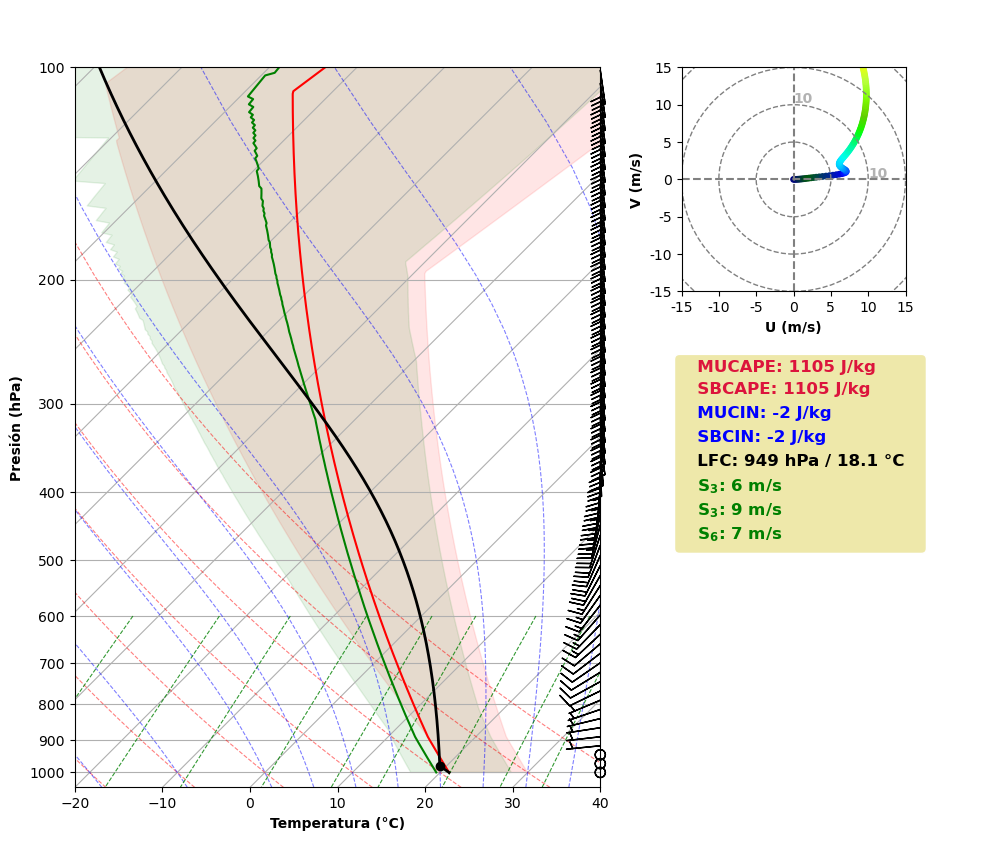

In [24]:
fig, skew, h, ax_indices = prepare_skewt_hodograph()
plot_sounding(fig, skew, h, ax_indices,base,show=False)
skew.shade_area(p , T_min-273.15,T_max-273.15 , which='negative', color='r',alpha=0.1)
skew.shade_area(p , Td_min-273.15,Td_max-273.15, which='both', color='g',alpha=0.1)
plt.show()